In [1]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import os.path as osp
import GCL.losses as L
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np
import pandas as pd
import math

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam


from scipy.io import loadmat
from dgl.nn.pytorch import GATConv, GraphConv, GATv2Conv, SumPooling

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics
from torch_geometric.nn import global_add_pool


In [2]:
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn
from dgl.utils import expand_as_pair


class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, num_heads=1):
        super(GConv, self).__init__()
        self.act = nn.SELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(num_heads * hidden_dim)
        self.layers = nn.ModuleList()
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True)
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True)
            )

    def forward(self, x, graph):
        z = x
        zs = []
        for i in range(self.num_layers):
            z = self.layers[i](graph, z)
            z = self.act(z)
            z = self.norm(z)
            zs.append(z)
        gs = [global_add_pool(z, None) for z in zs]
        z, g = [torch.cat(x, dim=1) for x in [zs, gs]]
        return z, g


class Encoder(nn.Module):
    def __init__(self, graph, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3):
        super(Encoder, self).__init__()

        self.encoder = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers, num_heads=num_heads).to(
            device)

        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.device = torch.device('cuda')

        self.project = torch.nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim * num_layers),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim * num_layers, hidden_dim * num_layers))


    def forward(self, x, graph, edge_index, edge_weight=None):
        aug1, aug2 = self.augmentor
        z, g = self.encoder(x, graph)

        x1, edge_index1, _ = aug1(x, edge_index)
        graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
        z1, g1 = self.encoder(x1, graph1)

        x2, edge_index2, _ = aug2(x, edge_index)
        graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
        z2, g2 = self.encoder(x2, graph2)

        return z, z1, z2, self.project(g1), self.project(g2)



In [3]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()



In [4]:

device = torch.device('cuda')
path = osp.join(osp.pardir, 'datasets', 'ACM')


In [5]:
# print(len(mat['MDM']))

In [6]:
# edge_index = []
# for i in tqdm(range(len(mat['PLP']))):
#     for j in range(len(mat['PLP'])):
#         if mat['PAP'][i][j] == 1:
#             edge_index.append([i, j])

graph_dict = {}
edge_index = []
adj = np.load(osp.join(path, 'acm_adj.npy'))
for i in tqdm(range(len(adj))):
    for j in range(len(adj)):
        if adj[i][j] == 1:
            edge_index.append([i, j])
print(len(edge_index))
edge_index = tensor(edge_index, dtype=torch.long).t().contiguous()
graph = dgl.graph((edge_index[0], edge_index[1]), num_nodes=len(adj)).to(device)
graph.remove_self_loop()
graph.add_self_loop()

edge_index = torch.stack(graph.edges())
print(edge_index.size())



100%|██████████| 3025/3025 [00:36<00:00, 83.02it/s]


26256
torch.Size([2, 26256])


In [7]:
x = tensor(np.load(osp.join(path, 'acm_feat.npy')), dtype=torch.float).to(device)
y = tensor(np.load(osp.join(path, 'acm_label.npy'))).to(device)
print(x.size())


torch.Size([3025, 1870])


In [8]:
del adj


model have 2776064 paramerters in total


(T): 100%|██████████| 200/200 [00:29<00:00,  6.77it/s, loss=5.13, con_loss=5.13, kl_loss=5.13]


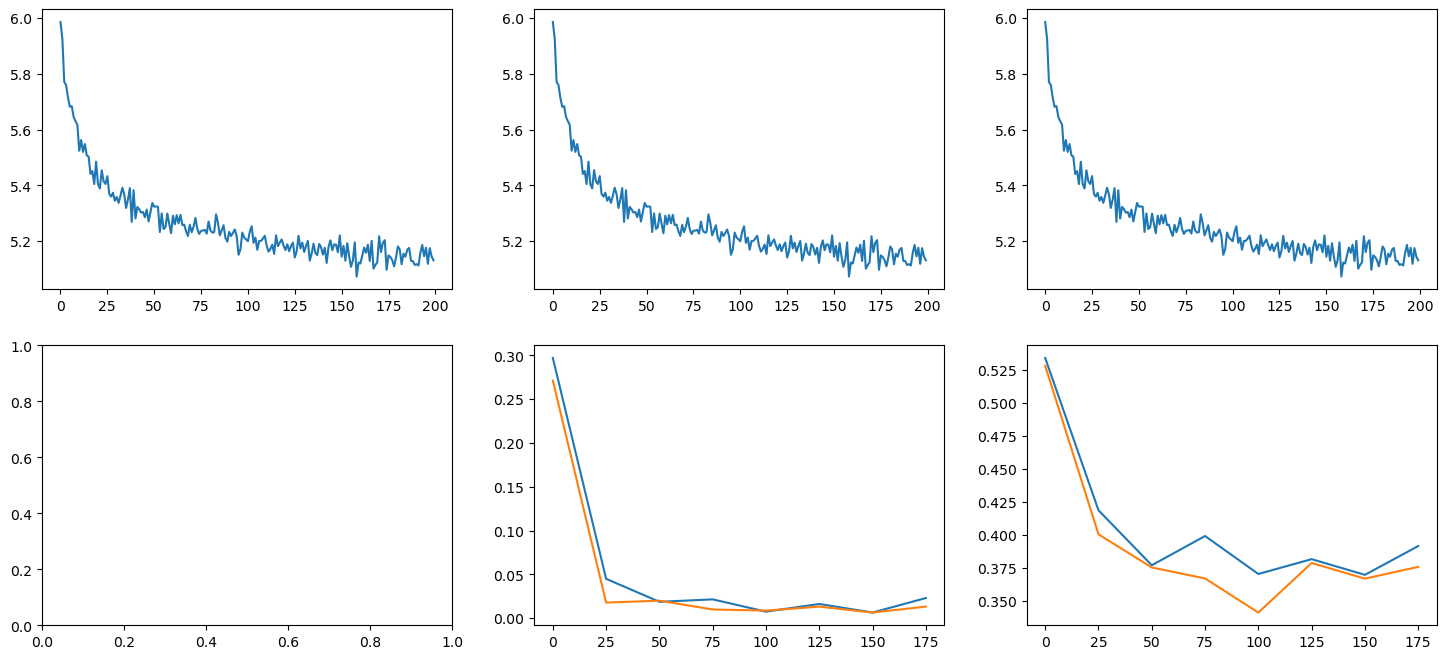

[MAX]ACC:  0.5342148760330578
[MAX]NMI:  0.29704553433311803
[MAX]ARI:  0.2711937293529045
[MAX]F1:  0.5282651494953239


In [9]:
from GCL.models import DualBranchContrast, WithinEmbedContrast


def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro


# def train(encoder_model, contrast_model, optimizer, x, graph, edge_index, clu_loss_func=ClusterLoss(class_num=4, temperature=1, device=device)):
def train(encoder_model, contrast_model, optimizer, x, graph, edge_index,
          clu_loss_func=DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=False).to(device)):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, g1, g2 = encoder_model(x, graph, edge_index)
    con_loss = contrast_model(z1, z2)
    # clu_loss = contrast_model(c1.t(), c2.t())
    # clu_loss = 0.01 * contrast_model(c1.t(), c2.t())
    # con_loss = 0.01 * con_loss
    loss = con_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), con_loss.item()


# aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.1)])
# aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureMasking(pf=0.1)])
# aug1 = A.Compose([A.EdgeRemoving(pe=0.0)])
# aug2 = A.Compose([A.EdgeRemoving(pe=0.0)])
aug1 = A.Identity()
aug2 = A.RandomChoice([A.RWSampling(num_seeds=1000, walk_length=10),
                           A.NodeDropping(pn=0.1),
                           A.FeatureMasking(pf=0.1),
                           A.EdgeRemoving(pe=0.1)], 1)
# encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=32, num_heads=4, n_clusters=4, num_layers=2).to(device)
encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=256, n_clusters=3, num_layers=4).to(device)

print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

# contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='G2G').to(device)
# contrast_model = nn.MSELoss()
# contrast_model = WithinEmbedContrast(loss=L.VICReg()).to(device)

# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer = Adam(encoder_model.parameters(), lr=0.001)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs = 200

kmeans = KMeans(n_clusters=3)

with tqdm(total=epochs, desc='(T)') as pbar:
    for epoch in range(epochs):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train(encoder_model, contrast_model, optimizer, x, graph, edge_index)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, _ = encoder_model(x, graph, edge_index)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(y.cpu(), pred)
            ari = adjusted_rand_score(y.cpu(), pred)
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)
            accs.append((epoch, acc))
            f1s.append((epoch, f1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs), losss)
axes[0][1].plot(range(epochs), kl_losss)
axes[0][2].plot(range(epochs), con_losss)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
D:\Python\anaconda3\envs\black\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


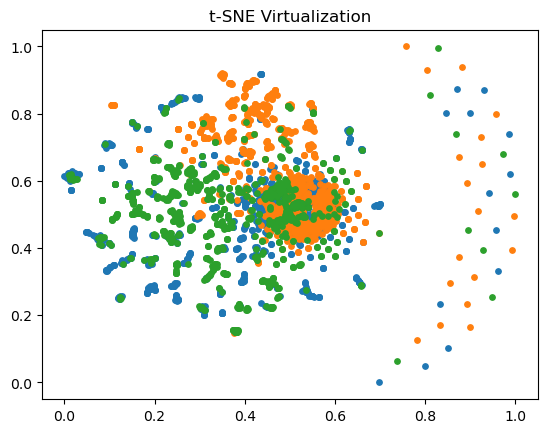

0.020839070449005535 0.008359521140274946


In [10]:
from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _ = encoder_model(x, graph, edge_index)
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(y.cpu() == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

nmi = normalized_mutual_info_score(y.cpu(), pred)
ari = adjusted_rand_score(y.cpu(), pred)

# acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(nmi, ari)

In [11]:
with torch.no_grad():
    encoder_model.eval()
    z, _, _, g1, g2 = encoder_model(x, graph, edge_index)
    pred = torch.argmax(pred, dim=1).cpu()
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

nmi = normalized_mutual_info_score(y.cpu(), pred)
ari = adjusted_rand_score(y.cpu(), pred)

# acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(nmi, ari)


TypeError: argmax(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _ = encoder_model(x, graph, edge_index)

pred = kmeans.fit_predict(z.cpu())

nmi = normalized_mutual_info_score(y.cpu(), pred)
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(y.cpu(), pred)
print('[INFO]ARI: ', ari)



In [ ]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

In [ ]:


with torch.no_grad():
    encoder_model.eval()
    z, _, _, g1, g2 = encoder_model(x, graph, edge_index)
print(g1.size(), g2.size())
